### MODEL

### Use Anaconda Terminal
# Always run ( conda activate gpu_env ) before all

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.4.1
True


In [3]:
import tensorflow as tf

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available.")
    for gpu in gpus:
        print("  Name:", gpu.name)
        print("  Type:", gpu.device_type)
else:
    print("GPU is not available.")

GPU is not available.


In [1]:
import os
import numpy as np
import pandas as pd
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

1. Load Metadata and Map Labels


In [ ]:
metadata = pd.read_csv('Dataset/participants.tsv', sep='\t')
print(metadata.head())

group_mapping = {'A': 0, 'F': 1, 'C': 2}
metadata['label'] = metadata['Group'].map(group_mapping)
print(metadata[['participant_id', 'Group', 'label']].head())

subject_labels = dict(zip(metadata['participant_id'], metadata['label']))

 succesfully ran the below code 
<p>
<p>
<p>0 bad epochs dropped
<p>Effective window size : 0.512 (s)
<p>Loading: Dataset\derivatives\sub-088\eeg\sub-088_task-eyesclosed_eeg.set
<p>Filtering raw data in 1 contiguous segment
<p>Setting up band-pass filter from 0.5 - 45 Hz
<p>
<p>FIR filter parameters
<p>---------------------
<p>Designing a one-pass, zero-phase, non-causal bandpass filter:
<li> Windowed time-domain design (firwin) method
<li> Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
<li>> Lower passband edge: 0.50
<li> Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
<li> Upper passband edge: 45.00 Hz
<li> Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
<li>Filter length: 3301 samples (6.602 sec)
<p>
<p>C:\Users\Microsoft\AppData\Local\Temp\ipykernel_23456\489852142.py:50: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and <p>epoching around these events.
<p>  raw = mne.io.read_raw_eeglab(set_file_path, preload=True)
<p>Not setting metadata
<p>783 matching events found
<p>No baseline correction applied
<p>0 projection items activated
<p>Using data from preloaded Raw for 783 events and 1000 original time points ...
<p>[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
<p>0 bad epochs dropped
<p>Effective window size : 0.512 (s)
<p>Final training feature shape: (55764, 19, 5, 1)
<p>Final test feature shape: (13942, 19, 5, 1)
<p>Final label vector shape: (69706,)

In [ ]:
import os
import numpy as np
import pandas as pd
import mne
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

metadata = pd.read_csv('Dataset/participants.tsv', sep='\t')
group_mapping = {'A': 0, 'F': 1, 'C': 2}
metadata['label'] = metadata['Group'].map(group_mapping)
subject_labels = dict(zip(metadata['participant_id'], metadata['label']))

# -----------------------------
# 2. Define Paths and Initialize Containers

derivatives_path = os.path.join('Dataset', 'derivatives')
subject_folders = [os.path.join(derivatives_path, d) for d in os.listdir(derivatives_path) if d.startswith('sub-')]

all_features = []
all_epoch_subject_ids = []

freq_bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 25),
    "gamma": (25, 45),
}

# -----------------------------
# 3. Loop Over All Subject Folders and Process EEG Data

for subject_folder in subject_folders:
    eeg_folder = os.path.join(subject_folder, 'eeg')
    set_files = [f for f in os.listdir(eeg_folder) if f.endswith('.set')]
    if not set_files:
        continue
    
    set_file_path = os.path.join(eeg_folder, set_files[0])
    print("Loading:", set_file_path)
    
    raw = mne.io.read_raw_eeglab(set_file_path, preload=True)
    raw.filter(0.5, 45, fir_design='firwin')
    
    # Create fixed-length epochs (2 seconds duration, 1 second overlap)
    epochs = mne.make_fixed_length_epochs(raw, duration=2.0, overlap=1, preload=True)
    # Use the events array length since bad epochs may not be dropped:

    psd = epochs.compute_psd(method="welch", fmin=0.5, fmax=45)
    psds, freqs = psd.get_data(return_freqs=True)
    
    band_power = {}
    for band, (fmin, fmax) in freq_bands.items():
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_power[band] = psds[:, :, idx].mean(axis=-1)
    
    bp_abs = np.stack(list(band_power.values()), axis=-1)
    total_power = bp_abs.sum(axis=-1, keepdims=True)
    rbp_relative = bp_abs / total_power

    features = rbp_relative.reshape(rbp_relative.shape[0],
                                    rbp_relative.shape[1],
                                    rbp_relative.shape[2], 1)
    
    all_features.append(features)
    subject_id = os.path.basename(subject_folder)
    num_epochs = features.shape[0]
    all_epoch_subject_ids.extend([subject_id] * num_epochs)

# Concatenate features across all subjects
X = np.concatenate(all_features, axis=0)
n_channels, n_freqs, n_times = X.shape[1:]
y = np.array([subject_labels[pid] for pid in all_epoch_subject_ids])

# Reshape for scaling: (n_epochs, n_channels, n_freqs, n_times) → (n_epochs, -1)
X_reshaped = X.reshape(X.shape[0], -1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape back to original shape
X_train = X_train.reshape(X_train.shape[0], n_channels, n_freqs, n_times)
X_test = X_test.reshape(X_test.shape[0], n_channels, n_freqs, n_times)

print("Final training feature shape:", X_train.shape)
print("Final test feature shape:", X_test.shape)
print("Final label vector shape:", y.shape)

In [ ]:
print(len(all_epoch_subject_ids))  # Should match 69706


69706


In [ ]:
print("X shape:", X.shape)  # Should be (num_samples, 19, 5, 1)
print("X min/max:", np.min(X), np.max(X))  # Should be properly scaled
print("X mean/std:", np.mean(X), np.std(X))  # Should not be extreme values


X shape: (69706, 19, 5, 1)
X min/max: 5.687052153233299e-05 0.9968445487234848
X mean/std: 0.2000000000000001 0.30650708216262385


In [ ]:
print("y dtype:", y.dtype)  # Must be int


y dtype: int32


In [ ]:
import numpy as np
print("Unique labels in y:", np.unique(y))
print("Label counts:", np.bincount(y))


Unique labels in y: [0 1 2]
Label counts: [29081 16556 24069]


In [ ]:
print("Shape before last Conv2D:", X.shape)


Shape before last Conv2D: (69706, 19, 5, 1)


In [ ]:
# 4. Model Definition 

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import DepthwiseConv2D, Multiply, Add, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import SpatialDropout2D  # Add to your imports

from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D,  # Explicit Conv2D import
    BatchNormalization, MaxPooling2D,
    Flatten, Dense, Dropout, Multiply,
    GlobalAveragePooling2D
)


def create_model(input_shape, nb_classes):
    inputs = Input(shape=input_shape)
    
    # 1. Depthwise Separable Convolution
    x = DepthwiseConv2D((3, 3), depth_multiplier=2, activation='relu', padding='same')(inputs)
    x = Conv2D(32, (1, 1), activation='relu')(x)  # Pointwise convolution
    x = BatchNormalization()(x)
    
    # 2. Frequency-Specific Processing
    x = Conv2D(64, (1, 5), activation='relu', padding='same',  # Kernel spans all channels
               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)  # Frequency-axis kernel
    
    # 3. Channel Attention (Squeeze-and-Excite Lite)
    squeeze = GlobalAveragePooling2D()(x)
    excitation = Dense(64//4, activation='relu')(squeeze)
    excitation = Dense(64, activation='sigmoid')(excitation)
    x = Multiply()([x, excitation])
    
    # 4. Adaptive Pooling
    x = MaxPooling2D((2, 2))(x)
    x = SpatialDropout2D(0.3)(x)  # Better than Dropout for spatial data
    
    # 5. Frequency Band Consolidation
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # 6. Regularized Classification Head
    x = Flatten()(x)
    x = Dense(64, activation='relu', kernel_constraint=max_norm(3.))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(nb_classes, activation='softmax')(x)
    
    return Model(inputs, outputs)


# 5. Model Training 

# Get input dimensions
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])  # (channels, freq_bands, 1)
nb_classes = len(np.unique(y))

# Create and compile model
model = create_model(input_shape, nb_classes)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

# Save model
model.save('alzheimer_eeg_model')

Epoch 1/100
1743/1743 [==============================] - 11s 6ms/step - loss: 1.0031 - accuracy: 0.5077 - val_loss: 0.8863 - val_accuracy: 0.6076
Epoch 2/100
1743/1743 [==============================] - 10s 6ms/step - loss: 0.8998 - accuracy: 0.5751 - val_loss: 0.8175 - val_accuracy: 0.6325
Epoch 3/100
1743/1743 [==============================] - 11s 6ms/step - loss: 0.8378 - accuracy: 0.6121 - val_loss: 0.7585 - val_accuracy: 0.6710
Epoch 4/100
1743/1743 [==============================] - 11s 6ms/step - loss: 0.7927 - accuracy: 0.6415 - val_loss: 0.7447 - val_accuracy: 0.6551
Epoch 5/100
1743/1743 [==============================] - 11s 6ms/step - loss: 0.7574 - accuracy: 0.6606 - val_loss: 0.7129 - val_accuracy: 0.6808
Epoch 6/100
 226/1743 [==>...........................] - ETA: 8s - loss: 0.7261 - accuracy: 0.6722

KeyboardInterrupt: 

In [ ]:

# Save model
model.save('alzheimer_eeg_model')

INFO:tensorflow:Assets written to: alzheimer_eeg_model\assets


c:\Users\Microsoft\.conda\envs\gpu_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


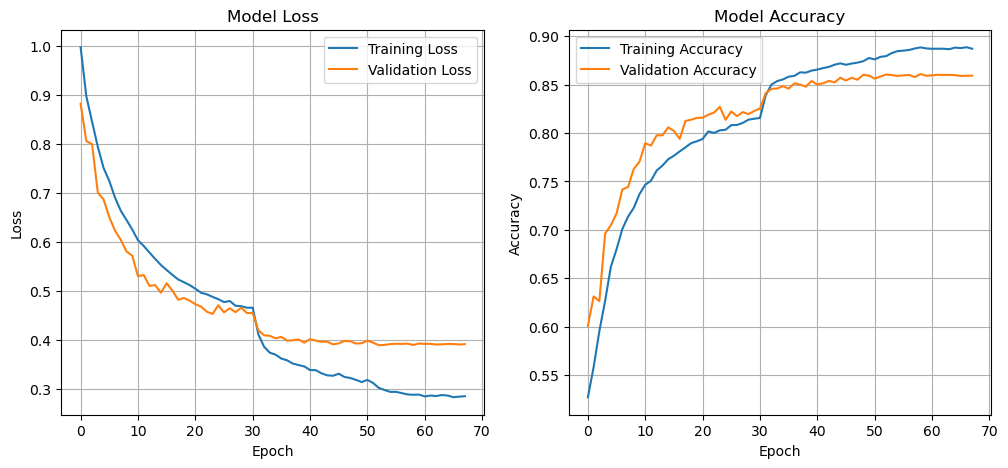

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Create a figure with two subplots side-by-side
    plt.figure(figsize=(12, 5))
    
    # -----------------------------
    # Plot Model Loss
    # -----------------------------
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # -----------------------------
    # Plot Model Accuracy
    # -----------------------------
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Display the plots
    plt.show()

# Call the function to plot the training history
plot_training_history(history)


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 19, 5, 1)]   0                                            
__________________________________________________________________________________________________
depthwise_conv2d_8 (DepthwiseCo (None, 19, 5, 2)     20          input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 19, 5, 32)    96          depthwise_conv2d_8[0][0]         
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 19, 5, 32)    128         conv2d_20[0][0]                  
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate and save a diagram of the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

NameError: name 'model' is not defined

Confusion Matrix:
[[4827  475  422]
 [ 299 2906  130]
 [ 373  245 4265]]


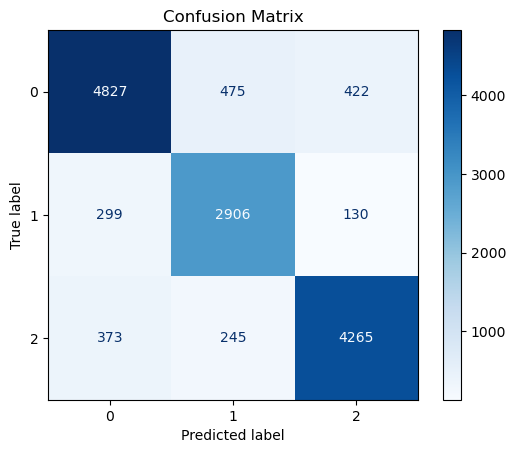

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtain predictions from the model on the test set
y_pred_prob = model.predict(X_test)
# For multi-class classification using softmax loss, take the argmax.
y_pred = np.argmax(y_pred_prob, axis=1)

# If you are doing binary classification and using a single output neuron with sigmoid:
# y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optionally, print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


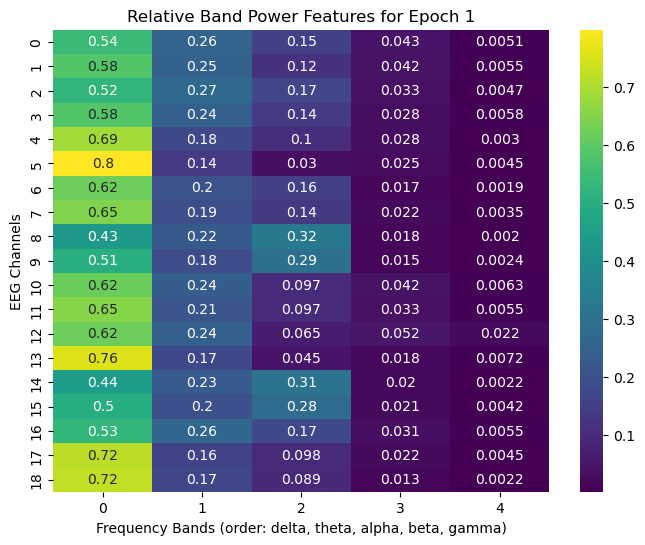

In [ ]:
import seaborn as sns

# Take the first epoch's relative band power (shape: (n_channels, n_bands))
rbp_example = rbp_relative[464, :, :]
plt.figure(figsize=(8, 6))
sns.heatmap(rbp_example, annot=True, cmap='viridis', cbar=True)
plt.title("Relative Band Power Features for Epoch 1")
plt.xlabel("Frequency Bands (order: delta, theta, alpha, beta, gamma)")
plt.ylabel("EEG Channels")
plt.show()
